# XGC Distribution Function Analysis
Contains codes to explore the XGC distribution functions

## Setup

In [23]:
# %% Imports
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate

import gudhi

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')
geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='midplane', **geom_files)

geom.assemble_flux_surf_avg()

xgcFields = XgcFieldHandler(xgcdata, geom)

# Load phase velocities
tind = 400
uph = np.load('./outputs/phase_vel.npz')['u_lstsq']
interp_uph = scipy.interpolate.CubicSpline(geom.psi_surf, uph[tind,:])

zonalFields = XgcZonalFieldHandler(eq, xgcdata, tind)

## Analysis

In [16]:
nxi = 10
xi_grid = np.linspace(-1, 1, nxi)[nxi//2:-1]
xi_grid

#xi_grid = np.array([np.sqrt(0.33)])

array([0.11111111, 0.33333333, 0.55555556, 0.77777778])

In [17]:
# %% Set up constants of motion

## Set up the rotating frame
# NOTE: Be careful about unit conventions, XGC is in sec while we work in millisec

omega_frame = -uph[tind,196]*geom.q_surf[196]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(xgcdata['t'][tind], omega_frame, tind)
t0 = rotating_frame.t0

## Choose which particle properties to use
pp = particle_motion.deut

## Set initial position
#r0 = 2.2259
r0 = eq.interp_router(geom.psi_surf[196]/eq.psix)
z0 = geom.zaxis
x0 = np.array([r0, 0.0, z0])

# Compute magnetic field at initial position
bv = eq.compute_bv(x0[0], x0[2])
modb = np.linalg.norm(bv)
bu = bv / modb

## Compute the rotation frequency and the mean parallel velocity
psi0 = eq.interp_psi.ev(x0[0], x0[2])
omega0 = -zonalFields.interp_phi(psi0, nu=1)*zonalFields.scale_conversion()
vll_mean = eq.interp_ff(psi0) * omega0 / modb

## Determine the initial values of the integrals

# Particle kinetic energy in keV and cos(pitch angle)
ev0 = 0.78
xi_grid = np.linspace(-1, 1, 10)[5:-1]
# Set the initial parallel velocity
vll_grid = vll_mean + pp.vt * xi_grid * np.sqrt(ev0)
#vll0 = vll_mean + pp.vt * xi0 * np.sqrt(ev0)
# Initial magnetic moment
mu_grid = pp.m * (1-xi_grid**2) * (pp.vt * np.sqrt(ev0))**2 / 2 / modb

ham_grid = np.zeros_like(xi_grid)
lphi_grid = np.zeros_like(xi_grid)
# Compute the Hamiltonian and the parallel velocity for each xi
for i in range(len(xi_grid)):
    ham_grid[i], lphi_grid[i] = particle_tools.compute_integrals_dk(t0, np.concatenate((x0, [vll_grid[i], mu_grid[i]])), eq, pp, zonalFields, rotating_frame)

In [18]:
# %% Load the reference temperatures and other info that are used for normalization

mesh_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f0.mesh.bp"

with FileReader(mesh_file) as s:
    f0_T_ev = s.read('f0_T_ev')
    f0_smu_max = s.read('f0_smu_max')
    f0_vp_max = s.read('f0_vp_max')

# NOTE: it appears that f0_T_ev[1,:] is the ion temperature
f0_Ti_ev = f0_T_ev[1,:]

In [19]:
# %% Code to load and interpolate the gyrokinetic distribution function

## Load the 
# Load the f_xgc data
f0_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.orbit.f0.08000.bp"

fp_interp = np.full((geom.nnode, len(xi_grid)), np.nan)
fn_interp = np.full((geom.nnode, len(xi_grid)), np.nan)

fp_physical = np.full((geom.nnode, len(xi_grid)), np.nan)
fn_physical = np.full((geom.nnode, len(xi_grid)), np.nan)

f_mask = np.zeros((geom.nnode, len(xi_grid)), dtype=bool)

ksurf0, ksurf1 = 180, 220
#ksurf0, ksurf1 = 194, 197

with FileReader(f0_file) as s:
    # Get number of toroidal planes, and dimension in mu and v_||
    nphi = s.read('nphi')
    nmu = s.read('mudata')
    nvp = s.read('vpdata')

    # Prepare the coordinate grids
    xgc_vpara = np.linspace(-f0_vp_max, f0_vp_max, nvp)
    xgc_vperp = np.linspace(0, f0_smu_max, nmu)

    # Iterate over the nodes
    for knode in tqdm(range(geom.breaks_surf[ksurf0], geom.breaks_surf[ksurf1+1])):

        ## Spatial coordinates
        # Get the (R,Z) coordinates of the node
        r, z = geom.rz_node[knode,:]
        # Get varphi of the toroidal plane; note that f0 is on half-integer planes starting at -1/2 (?)
        varphi = 2*np.pi/48 * -0.5

        ## Magnetic geometry stuff
        psi_ev, ff_ev = eq.compute_psi_and_ff(np.array([r]), np.array([z]))
        bv, bu, modb, gradmodb, curlbu = eq.compute_geom_terms(np.array([r]), psi_ev, ff_ev)

        # Thermal velocity in meters/millisec, which are my unit conventions
        vt = np.sqrt(f0_Ti_ev[knode]*1e-3 / pp.m)

        ## Load the distribution function and prepare it for interpolation
        f_xgc = np.squeeze(s.read('i_f', start=[0, 0, knode, 0], count=[1,nmu,1,nvp]))
        xgc_interp = scipy.interpolate.RegularGridInterpolator((xgc_vperp, xgc_vpara), f_xgc, method='cubic')



        ## Compute normalized velocities
        for kxi in range(len(xi_grid)):
            ## Unmask nodes that we iterate over
            f_mask[knode, kxi] = True

            # Unpack the values of the integrals of motion
            mu0 = mu_grid[kxi]
            vll0 = vll_grid[kxi]
            ham0 = ham_grid[kxi]
            lphi0 = lphi_grid[kxi]

            # Normalized perpendicular velocity
            vperp_n = np.sqrt(2 * mu0 * modb[0] / pp.m) / vt
            # Parallel energy
            kll, pll_mean = particle_tools.compute_parallel_energy(t0, r, z, varphi, mu0, ham0, lphi0, eq, pp, xgcFields, rotating_frame)
            if kll < 0:
                # If parallel energy is negative, skip this node
                f_mask[knode,kxi] = False
                continue

                # Positive and negative parallel velocities
            vllp = (pll_mean + np.sqrt(2 * pp.m * kll) / pp.m)
            vlln = (pll_mean - np.sqrt(2 * pp.m * kll) / pp.m)
            vparap_n = vllp / vt
            vparan_n = vlln / vt
            
            fp_interp[knode,kxi] = xgc_interp((vperp_n, vparap_n))
            fn_interp[knode,kxi] = xgc_interp((vperp_n, vparan_n))

            ## Compute the conversion factor from XGC distribution function to physical distribution function
            bstarp = bv[:,0] + (pp.m / pp.z) * curlbu[0] * vllp
            bstarn = bv[:,0] + (pp.m / pp.z) * curlbu[0] * vlln
            bstarllp = np.sum(bu[:,0]*bstarp, axis=0)
            bstarlln = np.sum(bu[:,0]*bstarn, axis=0)

            fp_physical[knode,kxi] = np.sqrt(modb[0]/2/mu0) / bstarllp * fp_interp[knode,kxi]
            fn_physical[knode,kxi] = np.sqrt(modb[0]/2/mu0) / bstarlln * fn_interp[knode,kxi]




  0%|          | 0/27043 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
# %% Save or load the distribution functions

#np.savez(R'D:\Documents\IFS\hmode_jet\outputs\f_xgc.npz', fp_physical=fp_physical, fn_physical=fn_physical, f_mask=f_mask, xi_grid=xi_grid)
f_xgc_data = np.load(R'D:\Documents\IFS\hmode_jet\outputs\f_xgc.npz')
fp_physical = f_xgc_data['fp_physical']
fn_physical = f_xgc_data['fn_physical']
f_mask = f_xgc_data['f_mask']
xi_grid = f_xgc_data['xi_grid']

In [113]:
# %% Find the bounce points of the distribution function

def find_bounce_points(fp, fn):
    """
    Function for finding the bounce points in the interpolated distribution function.
    The basic strategy is on each flux surface, find nodes which neighbor NaN values; these
    will be the bounce points.

    Returns a boolean array which is True at the bounce points, taken to be the last node
    which is finite.
    """

    fbounce = np.zeros_like(fp, dtype=bool)
    knode0, knode1 = geom.breaks_surf[ksurf0], geom.breaks_surf[ksurf1+1]

    for tri in geom.rz_tri.triangles:
        # Check if all nodes in the triangle are in the flux surface
        if tri[0] >= knode0 and tri[0] < knode1 and \
           tri[1] >= knode0 and tri[1] < knode1 and \
           tri[2] >= knode0 and tri[2] < knode1:
            # Check if any of the nodes are NaN
            if np.isnan(fp[tri]).any():
                # If so, any of nodes that are not NaN are bounce points
                for k in range(3):
                    if not np.isnan(fp[tri[k]]):
                        fbounce[tri[k]] = True
        
    return fbounce

fbounce = find_bounce_points(fp_physical[:,kxi], fn_physical[:,kxi])


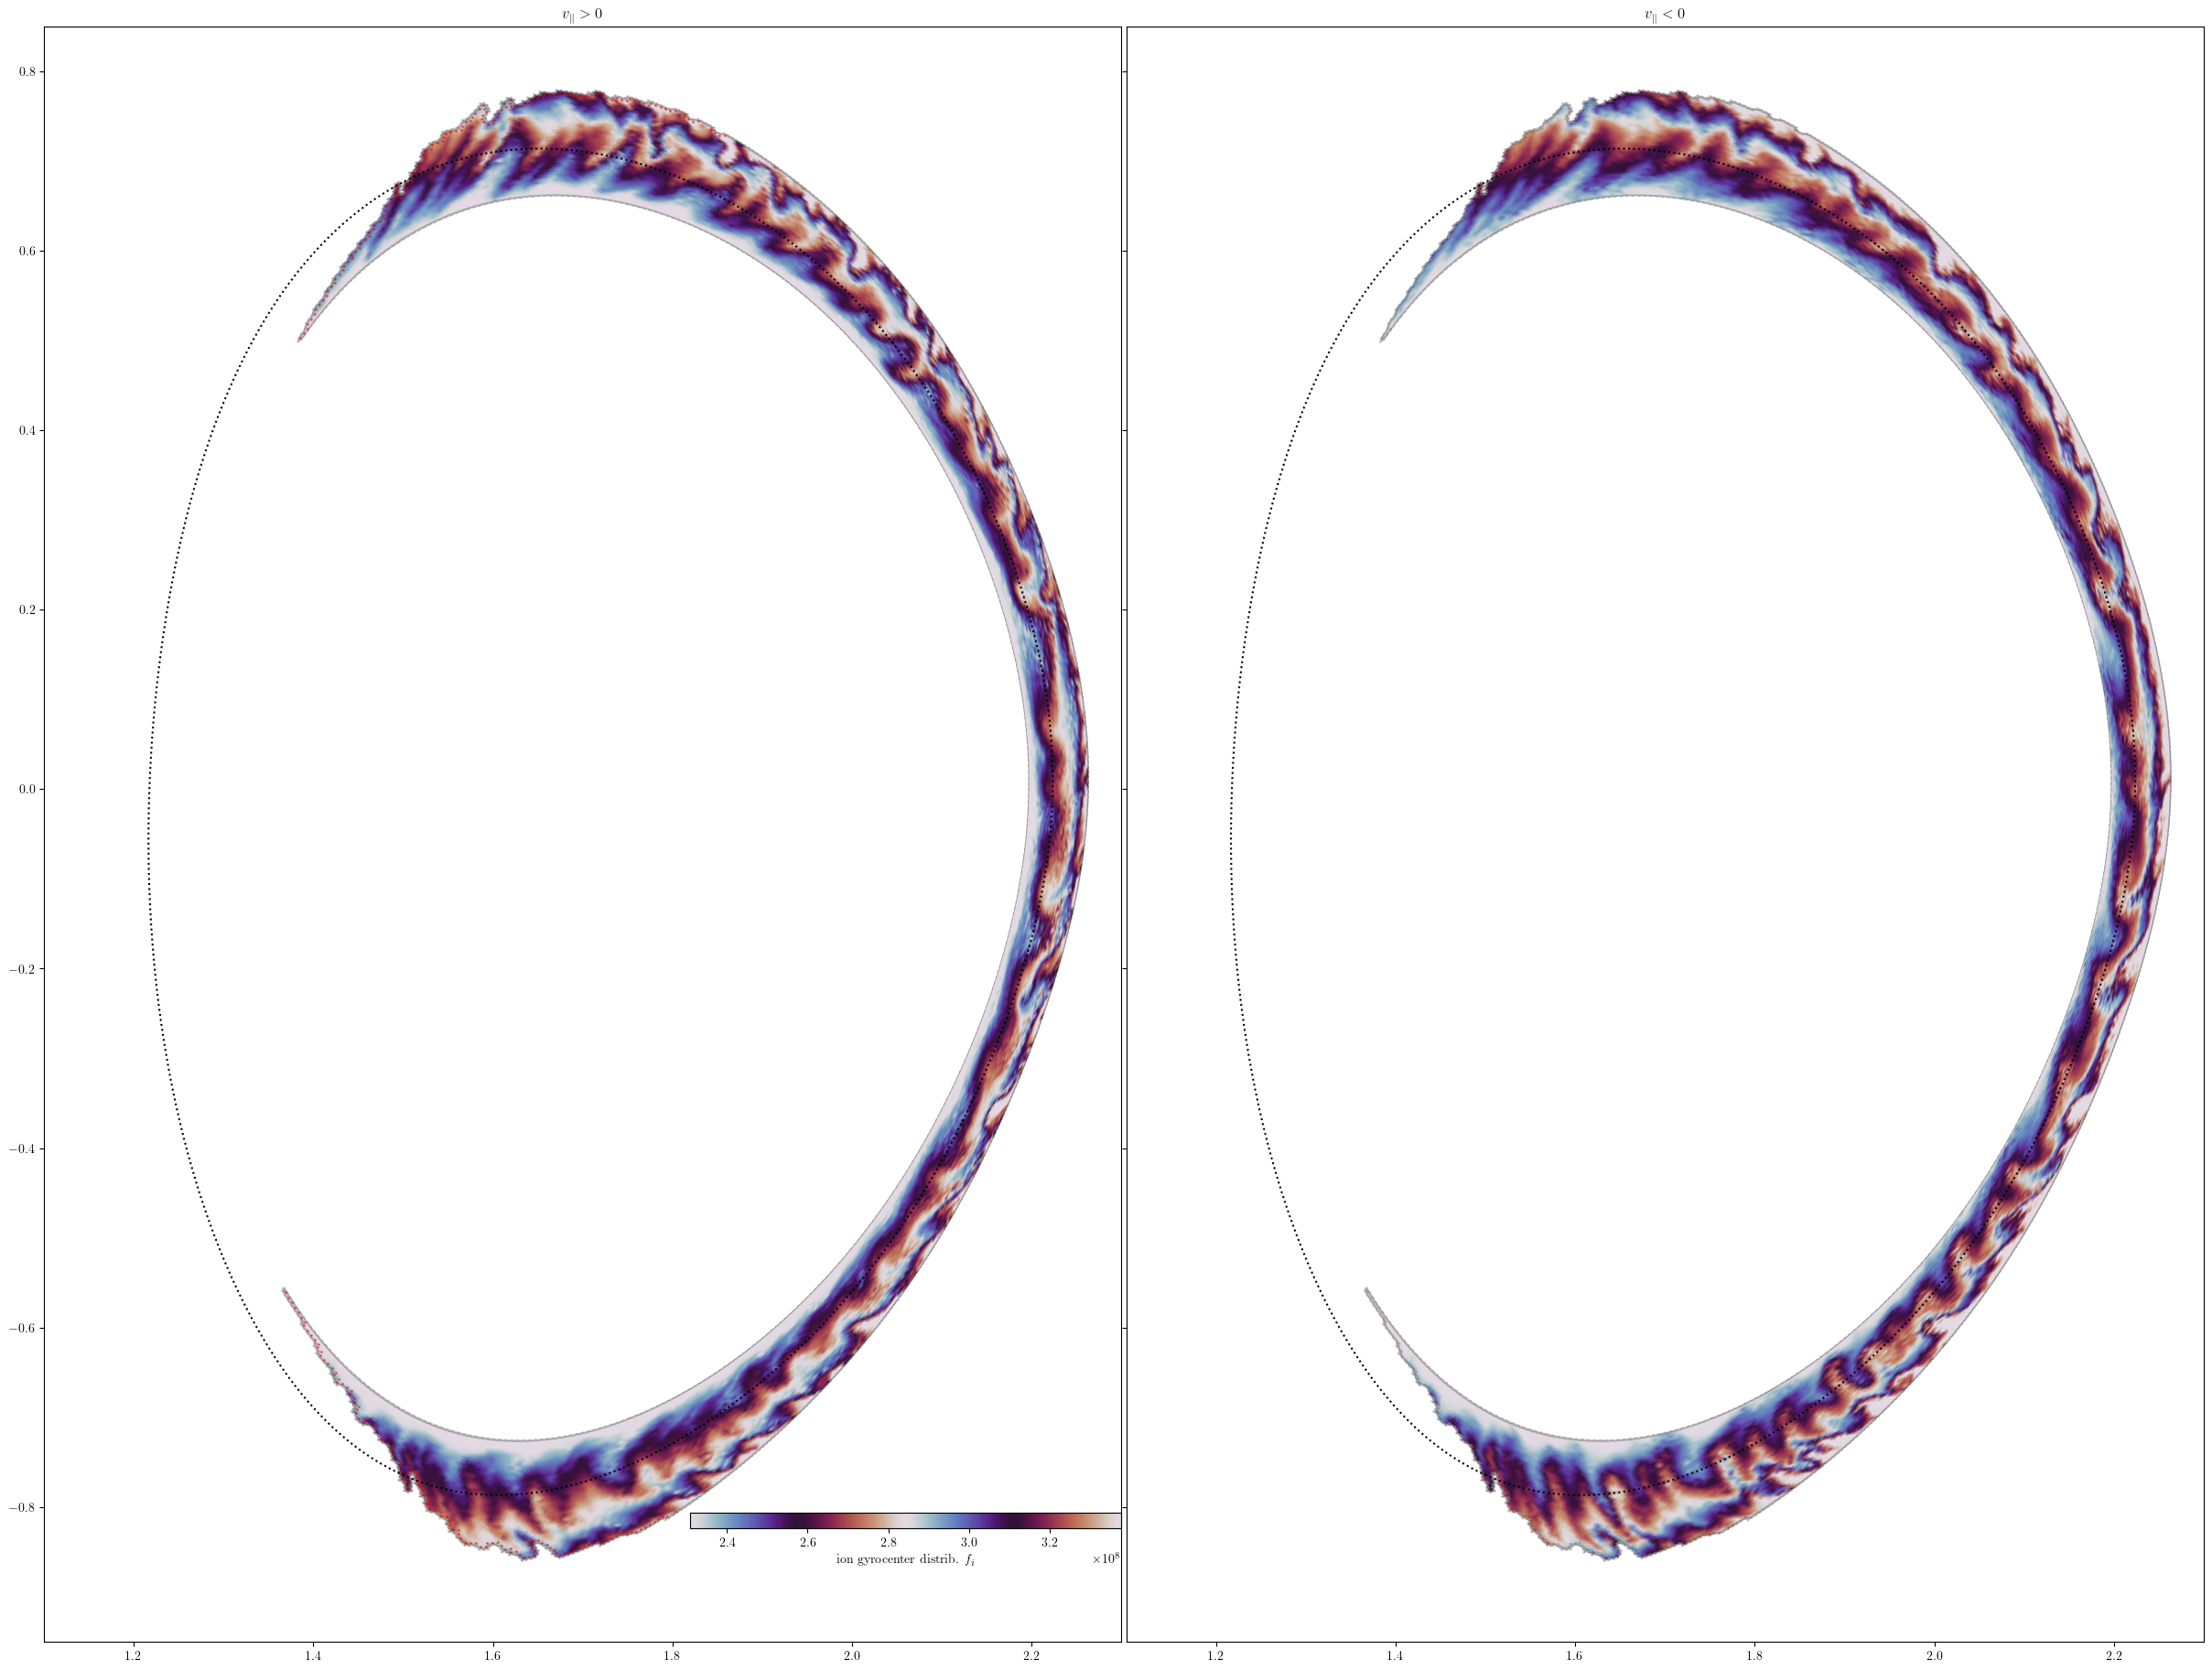

In [117]:
# %% Plot the distribution function
kxi = 2
fnorm = (pp.m/(2*np.pi))**(1.5)
fp_plot = fp_physical[:,kxi] * fnorm
fn_plot = fn_physical[:,kxi] * fnorm

tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 2, 256),1))
twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)

f_max = np.nanpercentile([fp_plot, fn_plot], 95)
f_min = np.nanpercentile([fp_plot, fn_plot], 5)

#plt.figure()

ksurf = np.searchsorted(-geom.q_surf, 2.0)
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]

fig, axs = plt.subplots(1, 2, width_ratios=[1, 1], figsize=(24, 18), sharex=True, sharey=True)

#geom.rz_tri.set_mask(f_mask)

#ax1 = plt.subplot(121)
axs[0].set_aspect('equal', adjustable='box')
axs[0].tripcolor(geom.rz_tri, fp_plot, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)
axs[0].plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

axs[0].set_title(R'$v_\parallel > 0$')

axs[0].set_xlim([1.1, 2.3])
axs[0].set_ylim([-0.95, 0.85])

axs[0].scatter(geom.rz_tri.x[fbounce], geom.rz_tri.y[fbounce], c='r', s=1, alpha=0.5)
axs[1].scatter(geom.rz_tri.x[fbounce], geom.rz_tri.y[fbounce], c='r', s=1, alpha=0.5)

#ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
axs[1].set_aspect('equal', adjustable='box')
#plt.axis('equal')
pc = axs[1].tripcolor(geom.rz_tri, fn_plot, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)
axs[1].plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

axs[1].set_title(R'$v_\parallel < 0$')

axs[1].set_xlim([1.1, 2.3])
axs[1].set_ylim([-0.95, 0.85])

cax = axs[0].inset_axes([0.6, 0.07, 0.4, 0.01])

plt.colorbar(pc, cax=cax, orientation='horizontal', label='ion gyrocenter distrib. $f_i$')

plt.tight_layout(pad=0.08)

## TDA Analysis

In [94]:
# %% Compute the persistence diagram

# Initialize gudhi simplex tree
st = gudhi.simplex_tree.SimplexTree()

# Sorts the data. NaNs are placed at the end
f_argsort = np.argsort(fp_physical[:,kxi])
num_valid = np.sum(np.isfinite(fp_physical[:,kxi]))

# Insert vertices with filtration values into the tree.
# TODO: Also do the negative distribution function
for i in range(num_valid):
    st.insert([f_argsort[i]], fp_physical[f_argsort[i],kxi])

# Insert edges and triangles with max filtration value of their vertices
for tri in geom.rz_tri.triangles:
    edges = [[tri[0], tri[1]], [tri[1], tri[2]], [tri[2], tri[0]]]
    for edge in edges:
        f_edge = np.max([fp_physical[edge[0],kxi], fp_physical[edge[1],kxi]])
        if np.isfinite(f_edge):
            st.insert(edge, f_edge)

    f_tri = np.max([fp_physical[tri[0],kxi], fp_physical[tri[1],kxi], fp_physical[tri[2],kxi]])
    if np.isfinite(f_tri):
        st.insert(tri, f_tri)

#st.initialize_filtration()
persistence = st.persistence()


In [95]:
rank1 = 0
rank0 = 0

for i, p in enumerate(persistence):
    if rank1 < 10 and p[0] == 1:
        print(i,p)
        rank1 += 1

    if rank0 < 10 and p[0] == 0:
        print(i,p)
        rank0 += 1

0 (1, (3.91224272975881e+16, inf))
1 (1, (5.6500325917860376e+16, 6.092624115353044e+16))
2 (1, (5.637286208914222e+16, 6.074007509043785e+16))
3 (1, (5.703209841310359e+16, 6.08902995905499e+16))
4 (1, (5.656055158477396e+16, 6.032665903891234e+16))
5 (1, (4.8515333736732e+16, 5.17647126597587e+16))
6 (1, (5.223954520724639e+16, 5.541153410048612e+16))
7 (1, (5.444286487423226e+16, 5.759853423307898e+16))
8 (1, (4.985399564492359e+16, 5.2947970916877176e+16))
9 (1, (4.8999853704603704e+16, 5.1853704378610376e+16))
1731 (0, (3.578114269383329e+16, inf))
1732 (0, (4.604948561352911e+16, 5.068701500793295e+16))
1733 (0, (4.358969954324953e+16, 4.776984530076526e+16))
1734 (0, (4.752462287006071e+16, 5.120282043284584e+16))
1735 (0, (5.018068804898563e+16, 5.344509783276968e+16))
1736 (0, (4.950620564097778e+16, 5.2760895917977224e+16))
1737 (0, (4.392385383032513e+16, 4.71348207685858e+16))
1738 (0, (4.191602880259581e+16, 4.472172619486929e+16))
1739 (0, (3.962443770897535e+16, 4.239878

1


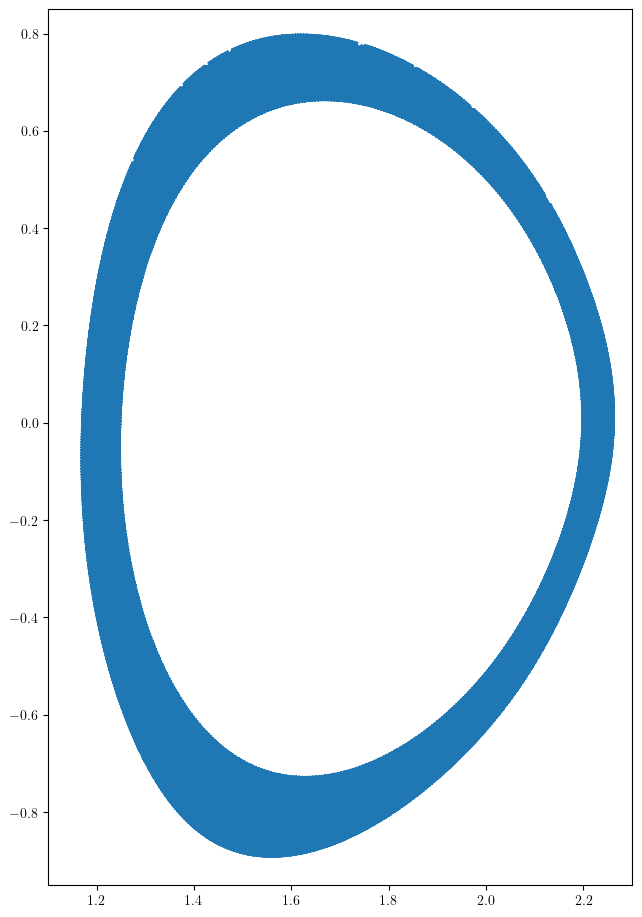

In [ ]:
# %% See what some of these connected components look like?

# %% Plot the distribution function
dim, (birth, death) = persistence[1]
print(dim)


#plt.figure()

fig, axs = plt.subplots(1, 1, figsize=(12, 9))

#geom.rz_tri.set_mask(f_mask)

def tri_mask(tri):
    f_tri = np.max([fp_physical[tri[0],kxi], fp_physical[tri[1],kxi], fp_physical[tri[2],kxi]])
    if np.isfinite(f_tri):
        return f_tri >= death
    else:
        return True

# Generate a mask
mask = list(tri_mask(tri) for tri in geom.rz_tri.triangles)

#ax1 = plt.subplot(121)
axs.set_aspect('equal', adjustable='box')
axs.triplot(geom.rz_tri.x, geom.rz_tri.y, geom.rz_tri.triangles, mask=mask)
axs.set_xlim([1.1, 2.3])
axs.set_ylim([-0.95, 0.85])

plt.tight_layout(pad=0.08)

Text(0.5, 1.0, 'Test')

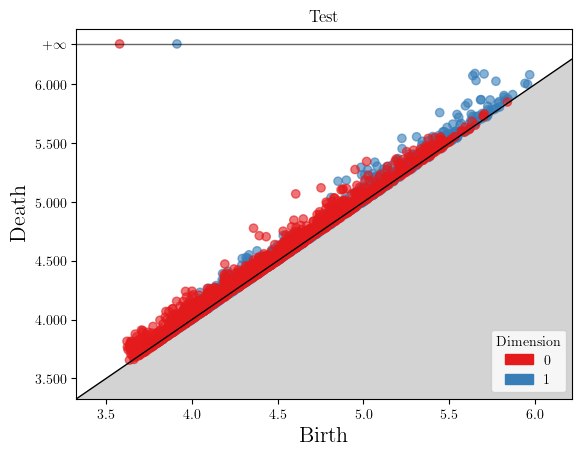

In [ ]:
fig, ax = plt.subplots(1,1)

p_norm = list((dim, (b*1e-16, d*1e-16)) for dim, (b,d) in persistence)

gudhi.plot_persistence_diagram(p_norm, axes=ax)
#ax.set_title('Test')


c:\Users\maple\miniconda3\envs\research-forge\Lib\site-packages\gudhi\persistence_graphical_tools.py:107: UserWarning: There are 3781 intervals given as input, whereas max_intervals is set to 1000.
  warnings.warn(


<Axes: title={'center': 'Persistence density'}, xlabel='Birth', ylabel='Death'>

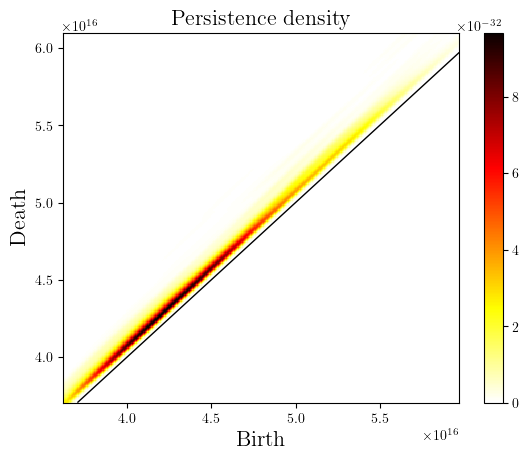

In [30]:
gudhi.plot_persistence_density(persistence)

## Restacking Analysis

In [24]:
# %% Compute restacked distribution functions

p_stack = []
f_stack = []

for kxi in range(len(xi_grid)):
    f_all = np.concatenate((fp_physical[:,kxi], fn_physical[:,kxi])) * fnorm
    f_all = f_all[~np.isnan(f_all)]
    f_stack.append(np.sort(f_all))
    p_stack.append(np.linspace(0, 1, len(f_all)))


In [36]:
# %% Plot the restacked distribution functions
fig, ax = plt.subplots(figsize=(8, 6))
for kxi in [0,1,2,3]:
    fmin = np.percentile(f_stack[kxi], 25)
    fmax = np.percentile(f_stack[kxi], 75)
    f_plot = (f_stack[kxi] - fmin) / (fmax - fmin)
    f_plot = f_stack[kxi]
    p_plot = np.arange(len(f_plot))
    ax.plot(p_plot, f_plot, label=f'xi = {xi_grid[kxi]:.2f}')

## Test Loading of Data

In [ ]:
# %% Test loading of f0

f0_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.orbit.f0.08000.bp"

with FileReader(f0_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    nodeid = 12000

    # Number of toroidal planes, and dimension in mu and v_||
    nphi = s.read('nphi')
    nmu = s.read('mudata')
    nvp = s.read('vpdata')

    # Load a single distribution function
    f_xgc = s.read('i_f', start=[0, 0, nodeid, 0], count=[1,nmu,1,nvp])
    f_xgc = np.squeeze(f_xgc)



variable_name: i_f 	AvailableStepsCount: 1 	Max: 6.4021e+18 	Min: 2.28167e-304 	Shape: 16, 33, 132048, 33 	SingleValue: false 	Type: double 
variable_name: imu1m1 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: inode1m1 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: iphi 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: mudata 	AvailableStepsCount: 1 	Max: 33 	Min: 33 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: ndata 	AvailableStepsCount: 1 	Max: 2216 	Min: 2216 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nmup1 	AvailableStepsCount: 1 	Max: 33 	Min: 33 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nnode 	AvailableStepsCount: 1 	Max: 132048 	Min: 132048 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nphi 	AvailableStepsCount: 1 	Max: 16 	Min: 16 	Shape:  	SingleValue: true 	Type: int

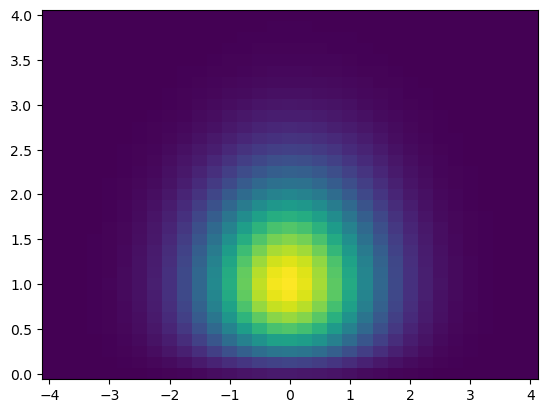

In [ ]:
plt.figure()

vperp_grid = np.linspace(0,4, nmu)
vpara_grid = np.linspace(-4,4, nvp)

plt.pcolormesh(vpara_grid, vperp_grid, f_xgc)

In [19]:
# %% Check data in the mesh file

mesh_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f0.mesh.bp"

with FileReader(mesh_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    f0_T_ev = s.read('f0_T_ev')

variable_name: f0_T_ev 	AvailableStepsCount: 1 	Max: 1195.43 	Min: 0.194034 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_den 	AvailableStepsCount: 1 	Max: 4.64276e+19 	Min: 1.87688e+17 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_dsmu 	AvailableStepsCount: 1 	Max: 0.125 	Min: 0.125 	Shape:  	SingleValue: true 	Type: double 
variable_name: f0_dvp 	AvailableStepsCount: 1 	Max: 0.25 	Min: 0.25 	Shape:  	SingleValue: true 	Type: double 
variable_name: f0_flow 	AvailableStepsCount: 1 	Max: -0 	Min: -0 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_grid_vol_vonly 	AvailableStepsCount: 1 	Max: 14.9034 	Min: 0.00241901 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_nmu 	AvailableStepsCount: 1 	Max: 32 	Min: 32 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: f0_nvp 	AvailableStepsCount: 1 	Max: 16 	Min: 16 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: f0_smu_max 	Available

In [38]:
# %% Check data in the volumes file

volumes_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.volumes.bp"

with FileReader(volumes_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

variable_name: diag_1d_npsi 	AvailableStepsCount: 1 	Max: 264 	Min: 264 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: diag_1d_vol 	AvailableStepsCount: 1 	Max: 0.0842871 	Min: 0.00368841 	Shape: 264 	SingleValue: false 	Type: double 



In [53]:
# %% Load 3d field data

# %% Check data in the mesh file

f3d_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f3d.08000.bp"

with FileReader(f3d_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    # Load the ion temperature data
    e_den = s.read('e_den', start=[0, 0], count=[132048, 1])
    i_T_perp = s.read('i_T_perp', start=[0, 0], count=[132048, 1])
    e_T_perp = s.read('e_T_perp', start=[0, 0], count=[132048, 1])

    # Load field data
    dpot = s.read('dpot', start=[0, 0], count=[132048, 1])

    time = s.read('time')
    step = s.read('step')

variable_name: dpot 	AvailableStepsCount: 1 	Max: 56.4656 	Min: -27.4515 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_ExB_enflux_en 	AvailableStepsCount: 1 	Max: 6939.91 	Min: -1972.18 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_ExB_flux_en 	AvailableStepsCount: 1 	Max: 3.06801e+19 	Min: -5.69339e+19 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_T_para 	AvailableStepsCount: 1 	Max: 1184.39 	Min: 0.0327014 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_T_perp 	AvailableStepsCount: 1 	Max: 1180.95 	Min: 0.193254 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den 	AvailableStepsCount: 1 	Max: 4.64131e+19 	Min: 5.43334e+15 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den_en 	AvailableStepsCount: 1 	Max: 1.75574e+19 	Min: 0 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_energy_en 	AvailableStepsCount: 1 	Max: 5.80275e+33

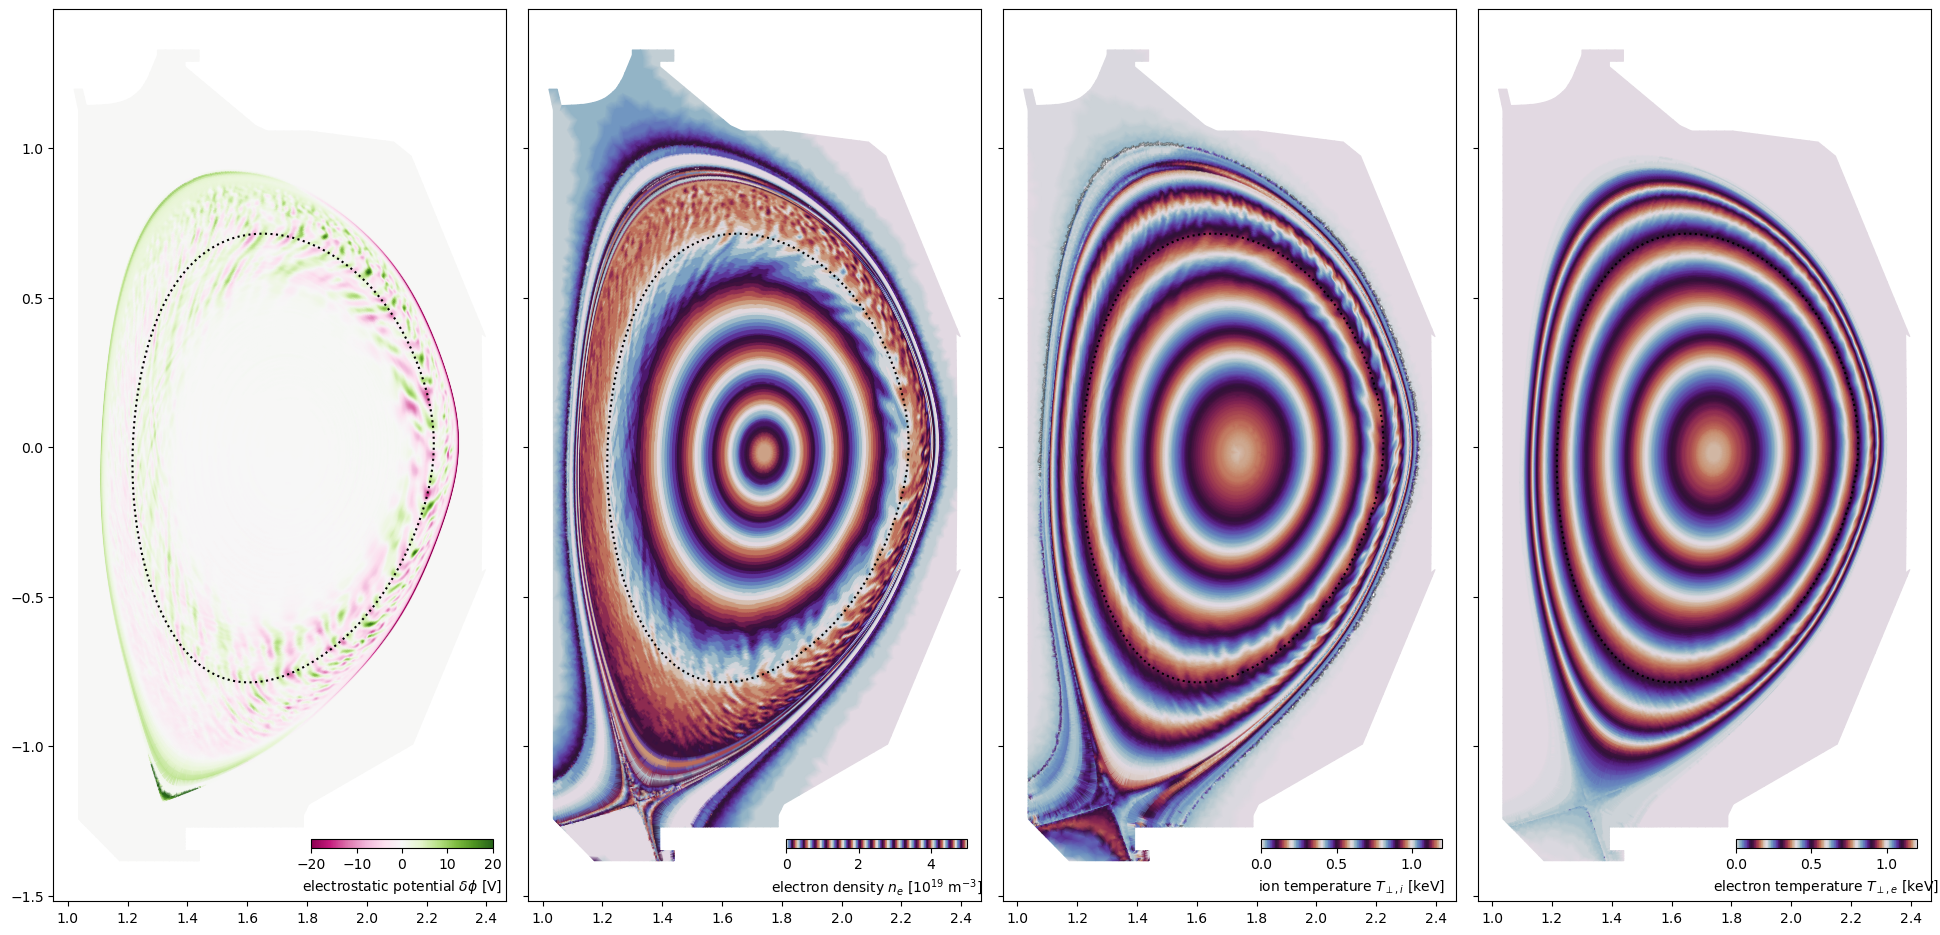

In [16]:
# %% Plot temperature data
tw_repeated_16 = mpl.cm.twilight(np.mod(np.linspace(0, 16, 256),1))
twr_cmap_16 = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated_16, N=256)

tw_repeated_8 = mpl.cm.twilight(np.mod(np.linspace(0, 6, 256),1))
twr_cmap_8 = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated_8, N=256)

fig, axs = plt.subplots(1, 4, figsize=(19.2,10.8), sharex=True, sharey=True)

ksurf = np.searchsorted(-geom.q_surf, 2.0)
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]

def plot_2d(ax, data, label, cmap, vmin=None, vmax=None):
    # Set aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Plot the data
    pc = ax.tripcolor(geom.rz_tri, data, shading='gouraud', rasterized=True, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

    # Make the colorbar
    cax = ax.inset_axes([0.57, 0.06, 0.4, 0.01])
    plt.colorbar(pc, cax=cax, orientation='horizontal', label=label)

plt.tight_layout(pad=0)

plot_2d(axs[0], dpot[:,0], R'electrostatic potential $\delta\phi$ [V]', 'PiYG', vmin=-20, vmax=20)
plot_2d(axs[1], e_den[:,0]*1e-19, R'electron density $n_e$ [$10^{19}$ m$^{-3}$]', twr_cmap_16, vmin=0, vmax=5)
plot_2d(axs[2], i_T_perp[:,0]*1e-3, R'ion temperature $T_{\perp,i}$ [keV]', twr_cmap_8, vmin=0, vmax=1.2)
plot_2d(axs[3], e_T_perp[:,0]*1e-3, R'electron temperature $T_{\perp,e}$ [keV]', twr_cmap_8, vmin=-0, vmax=1.2)





In [59]:
# %% Test flux surface averaging

den1, den1n = geom.flux_surf_avg(e_den[:,0], nodal=True)
den2 = geom.flux_surf_avg((e_den[:,0]-den1n)**2)
den3 = geom.flux_surf_avg((e_den[:,0]-den1n)**3)

plt.figure()
plt.plot(den3)

In [20]:
step

array(8000)

In [23]:
a = [1,2,3]
print(a[0:2])

[1, 2]
